## Import Package

In [19]:
import re
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import spacy

# import spacy model en_core_web_md
nlp = spacy.load('en_core_web_md')

## Clean Data

In [20]:
df = pd.read_csv('../data/spotify_songs.csv')

In [21]:
df.to_csv('../data/songs.gz', index=False, compression='gzip')

In [22]:
def clean_data(songs):
    """
    Input DataFrame
    ---------
    Return the new clean Data
    """
    # Copy data frame so it won't alter the input
    songs = songs.copy()
    
    # Drop NA
    songs = songs.dropna()
    
    # Select song in English
    songs = songs[songs['language']=='en']

    # Get rid of dublicates song that have (feat) or -
    songs['track_name'] = songs['track_name'].apply(lambda x: x.split('(')[0].strip())
    songs['track_name'] = songs['track_name'].apply(lambda x: x.split('-')[0].strip())
    
    # Drop dublicates song that have the same name and artist
    songs = songs.drop_duplicates(subset = ['track_name', 'track_artist'])
    
    # Subset the dataframe to only contain 3 columns. Reset index
    songs = songs[['track_name', 'track_artist', 'lyrics']].reset_index()
    
    return songs.drop(columns='index')
    
# Create a new clean Data Frame
spotify = clean_data(df)

In [23]:
spotify.head(10)

,track_name,track_artist,lyrics
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu..."
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U..."
2,Baby It's Cold Outside,CeeLo Green,I really can't stay Baby it's cold outside I'v...
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...
4,Soldier,James TW,"Hold your breath, don't look down, keep trying..."
5,Satisfy You,Diddy,All I want is somebody who's gonna love me for...
6,Tender Lover,Babyface,Feels good Everybody Tender lover Tender love ...
7,Hide Away,Blasterjaxx,"Don't run away, it's getting colder Our hearts..."
8,Limestone,Magic City Hippies,How many friends are you gonna set on fire? Ho...
9,Changes,2Pac,"I see no changes, wake up in the morning and I..."


In [24]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_name    12753 non-null  object
 1   track_artist  12753 non-null  object
 2   lyrics        12753 non-null  object
dtypes: object(3)
memory usage: 299.0+ KB


In [25]:
# Save the clean data into csv
spotify.to_csv('../data/trimmed_spotify.csv', index=False)

In [26]:
def clean_text(text):
    """
    Takes in text and returns a clean text which mean
    Non-alphabet are filtered out. 
    Replace multi white spaces with single white space
    """
    
    # order of operations - apply the expression from top to bottom
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"

    text = re.sub(non_alpha, ' ', text)
    text = re.sub(multi_white_spaces, " ", text)
    
    # apply case normalization 
    return text.lower().strip()

In [27]:
# Add new clean_lyrics col
spotify['clean_lyrics'] = spotify['lyrics'].apply(clean_text)

In [28]:
spotify.head()

,track_name,track_artist,lyrics,clean_lyrics
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",the trees are singing in the wind the sky blue...
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",na yeah spyderman and freeze in full effect uh...
2,Baby It's Cold Outside,CeeLo Green,I really can't stay Baby it's cold outside I'v...,i really can t stay baby it s cold outside i v...
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,get up out of my business you don t keep me fr...
4,Soldier,James TW,"Hold your breath, don't look down, keep trying...",hold your breath don t look down keep trying d...


## Model

In [29]:
def tokenize(document):
    """
    Takes a doc and returns a list of tokens in the form of lemmas.
    Stop words and punctuation are filtered out. 
    """
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [30]:
# Instantiate vectorizer object
tfidf_vect = TfidfVectorizer(tokenizer=tokenize, min_df=0.03, 
                        max_df=0.28)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf_vect.fit_transform(spotify['clean_lyrics'])

# View Feature Matrix as DataFrame
dtm = pd.DataFrame(data=dtm.todense(), columns=tfidf_vect.get_feature_names())
dtm

,act,afraid,ah,air,alive,alright,apart,arm,ask,ass,...,wouldn,write,wrong,x,y,ya,year,yes,yo,young
0,0.0,0.0,0.0,0.0,0.339891,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.140815,0.0,0.0,0.0,0.0,0.0,0.223397,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12748,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.154634,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
12749,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
12750,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
12751,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.269422


In [31]:
dtm.to_csv('../data/dtm.csv', index=False)

In [32]:
# Fit on DTM
nn = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(dtm)

In [33]:
model_filename = '../ml/nlp_model' 
joblib.dump(nn, open(model_filename, 'wb'))

In [34]:
def favorite_track(name, artist):
    """
    Receive the name and artist of a song then return the 5 most similar song
    --------
    Keyword arg:
    name -- name of the song (string)
    artist -- artist of the song (string)
    """
    
    # find the song index
    selected_song_index = spotify[(spotify['track_name']==name) & (spotify['track_artist']==artist)].index.tolist()
    selected_song = [dtm.iloc[selected_song_index[0]].values] # selected_song_index return a list of 1
    
    # return a list of indexes of similar songs
    _, neigh_index = nn.kneighbors(selected_song)
    
    # add similar songs to a list 
    song_list = []
    for i in neigh_index[0][1:]:
        song_list.append(f"{spotify['track_name'][i]} by {spotify['track_artist'][i]}")
    return song_list

In [35]:
favorite_track('Dumb Litty', 'KARD')

['We like to Party! by Vengaboys',
 'Gyal You A Party Animal by Charly Black',
 'Not Your Birthday by Allstar Weekend',
 'Party All the Time by Eddie Murphy',
 '1999 by Prince']

## Visualization

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [56]:
a = WordCloud(background_color='white', random_state=37).generate(spotify['clean_lyrics'][0])

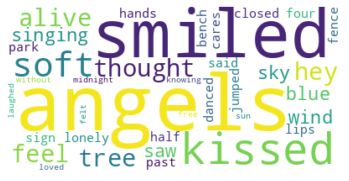

In [57]:
plt.imshow(a, interpolation='bilinear')
plt.axis('off')
plt.show()